In [1]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import warnings
import numpy as np

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# Load dataset
df=pd.read_csv("dataset.csv")

# Drop columns
drop_columns=['compression_ratio_zip','compression_ratio_winrar','compression_ratio_7zip',
              'compression_ratio_gzip','compression_ratio_bzip2','file_name']
df.drop(columns=drop_columns, inplace=True)

In [4]:
# Convert file_extension to categorical codes
df['file_extension']=df['file_extension'].astype('category').cat.codes

# Expand byte_distribution into 256 features
def expand_byte_distribution(bd_str):
    bd_dict=ast.literal_eval(bd_str)
    return [bd_dict.get(i, 0.0) for i in range(256)]

byte_features=df['byte_distribution'].apply(expand_byte_distribution)
byte_df=pd.DataFrame(byte_features.tolist(), columns=[f'byte_{i}' for i in range(256)])
df=pd.concat([df.drop(columns=['byte_distribution']), byte_df], axis=1)

In [5]:
# Features and labels
X=df.drop(columns=['best_tool'])
y=df['best_tool'] # Keep y as pandas Series for LabelEncoder

# Encode target label (best_tool) - Apply encoding here as well
le_target=LabelEncoder()
y_encoded=le_target.fit_transform(y) # Create encoded labels

# Train-validation split using the encoded labels
X_train, X_val, y_train_encoded, y_val_encoded=train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [6]:
max_depth_range=range(1, 31)  # 1 to 30
n_estimators_list=[10,25,50,75,100,150,200]

# Store validation accuracies for each (max_depth,n_estimators)
results={}
for n in n_estimators_list:
    accs=[]
    for depth in max_depth_range:
        rf = RandomForestClassifier(n_estimators=n,max_depth=depth,random_state=42)
        # Train on encoded labels
        rf.fit(X_train,y_train_encoded)
        # Predict on encoded labels
        y_val_pred=rf.predict(X_val)
        # Evaluate using encoded labels
        val_acc=accuracy_score(y_val_encoded,y_val_pred)
        accs.append(val_acc)
    results[n]=accs

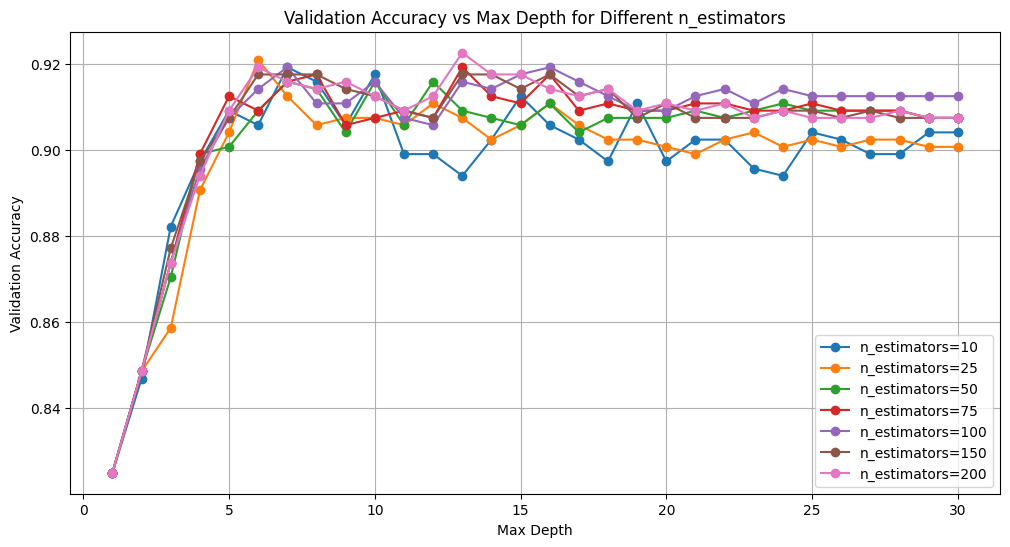

In [7]:
# Plotting
plt.figure(figsize=(12, 6))
for n in n_estimators_list:
    plt.plot(max_depth_range, results[n], marker='o', label=f'n_estimators={n}')
plt.title("Validation Accuracy vs Max Depth for Different n_estimators")
plt.xlabel("Max Depth")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.legend()
plt.show()

In [8]:
# Find best combination
best_acc=0
best_params=(None, None)
for n in n_estimators_list:
    for i,acc in enumerate(results[n]):
        if acc>best_acc:
            best_acc=acc
            best_params=(max_depth_range[i], n)

print(f"Best max_depth: {best_params[0]}, Best n_estimators: {best_params[1]}, with Validation Accuracy: {best_acc:.4f}")

Best max_depth: 13, Best n_estimators: 200, with Validation Accuracy: 0.9226


In [9]:
# Use the optimal depth and estimators found above, or a chosen combination
rf=RandomForestClassifier(n_estimators=best_params[1], max_depth=best_params[0], random_state=42)
rf.fit(X_train, y_train_encoded)

# Predict on the validation set using the best model
y_pred_encoded=rf.predict(X_val)

In [10]:
print("Accuracy:", accuracy_score(y_val_encoded, y_pred_encoded))
print("Classification Report:\n", classification_report(y_val_encoded, y_pred_encoded, target_names=le_target.classes_, zero_division=0))

Accuracy: 0.9225589225589226
Classification Report:
               precision    recall  f1-score   support

        7zip       0.80      0.81      0.81        95
      WinRar       0.00      0.00      0.00         3
       bzip2       0.96      0.94      0.95       365
        gzip       0.91      0.98      0.95       130
         zip       0.00      0.00      0.00         1

    accuracy                           0.92       594
   macro avg       0.54      0.55      0.54       594
weighted avg       0.92      0.92      0.92       594



In [11]:
import joblib
# Save model and label encoder in a dictionary
joblib.dump({'model': rf,'label_encoder': le_target},'RandomForest.joblib')

['RandomForest.joblib']